In [3]:

import sys
!{sys.executable} -m pip install xlrd
!{sys.executable} -m pip install cmocean


You are using pip version 8.0.3, however version 20.2.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.0.3, however version 20.2.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import xlrd
import numpy as np
%pylab inline
%matplotlib inline
import os
import glob
import h5py
import netCDF4
import math

from scipy import spatial
from scipy import signal
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.interpolate import griddata

import matplotlib as plot
import matplotlib.pyplot as plt

import cmocean as cmo
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


Plotting Function

In [2]:
def plotData(data,dExtent=None,ctrList=None,fsize=(10,10)):
    fig = plt.figure(figsize=fsize)
    ax1 = plt.gca()

    vmin = data.min()
    vmax = data.max()
    ax1.set_title('Depth (m)', fontsize=8)
    if dExtent is None:
        im1 = ax1.imshow(data,interpolation='nearest',
                         cmap=cmo.cm.ice_r,vmin=vmin, 
                         #extent = dExtent,
                         vmax=vmax)
    else:
        im1 = ax1.imshow(data,interpolation='nearest',
                         cmap=cmo.cm.ice_r,vmin=vmin-10, 
                         extent = dExtent,
                         vmax=vmax+10)
    
    if ctrList is not None:
        ax1.contour(data, ctrList, colors='w',  linewidths=2)
        
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    cbar1 = plt.colorbar(im1,cax=cax1)

    plt.tight_layout()
    plt.show()
    plt.close(fig)
    
    return

# Load Excel Spreadsheet

In [4]:

xyz = xlrd.open_workbook('Ex2.xlsx')

print (xyz.sheet_names())

['EX2', 'EX2_2.5', 'EX2_8.5', 'EX2_TD', 'EX2_C1', 'EX2_C2']


In [5]:
#xyz.sheet_by_name(u'Test_5m') #.shape

#xyz.sheet_by_name('Exposed_Small')
xyz.sheet_by_name('EX2')
#xyz.sheet_by_name(u'Test_5m')
#xyz.sheet_by_name('EX2_001_ro')
#xyz.sheet_by_name('ex1_003_point')

In [6]:
#page1=xyz.sheet_by_name(u'Exposed_Small')
page1=xyz.sheet_by_name(u'EX2')
#page1=xyz.sheet_by_name(u'EX2_001_ro')
#page1=xyz.sheet_by_name(u'ex1_003_point')
#page1=xyz.sheet_by_name(u'Test_5m')

## Read spreadsheet in python

In [7]:
x_ini=page1.col_values(0,start_rowx=1)
y_ini=page1.col_values(1,start_rowx=1)

#if (x_ini[0]==x_ini[1]):
 #   x_ini=page1.col_values(1,start_rowx=1)
#  y_ini=page1.col_values(0,start_rowx=1)
#else:
#        x_ini=page1.col_values(0,start_rowx=1)
#        y_ini=page1.col_values(1,start_rowx=1)
    


z=page1.col_values(2,start_rowx=1)
nx_ini=len(x_ini)
ny_ini=len(y_ini)


nz=len(z)

x=[0]*nx_ini
y=[0]*ny_ini

for i in range (0,nx_ini):
    x[i]=abs(x_ini[i]-x_ini[0])

for i in range (0,ny_ini):
    y[i]=abs(y_ini[i]-y_ini[0])
    
nx=len(list(set(x)))
ny=len(list(set(y)))

take the list of points from excel and transform these points as a numpy array

In [8]:
xarray = np.asarray(x_ini) #.reshape((nx,ny))
yarray = np.asarray(y_ini) #.reshape((nx,ny))
zarray = np.asarray(z) #.reshape((nx,ny))

pointsInput = np.vstack((xarray,yarray)).T

In [9]:
xmin = pointsInput[:,0].min()
xmax = pointsInput[:,0].max()
ymin = pointsInput[:,1].min()
ymax = pointsInput[:,1].max()

print('X min/max',xmin,xmax)
print('Y min/max',ymin,ymax)


X min/max 406863.830863 407648.830863
Y min/max 7401984.00918999 7402404.00918999


In [10]:
# Lower left point
id1 = np.where(pointsInput[:,0]==xmin)[0]
llc1 = pointsInput[id1,:][0]

# Upper left point
id2 = np.where(pointsInput[:,1]==ymax)[0]
ulc2 = pointsInput[id2,:][0]

# Upper right point
id3 = np.where(pointsInput[:,0]==xmax)[0]
urc3 = pointsInput[id3,:][0]

print(llc1,ulc2,urc3)

[ 406863.830863   7402151.00918999] [ 407591.830863   7402404.00918999] [ 407648.830863   7402238.00918999]


In [11]:
# Length of each edges
xlen = np.sqrt((urc3[0]-ulc2[0])**2+(urc3[1]-ulc2[1])**2)
ylen = np.sqrt((llc1[0]-ulc2[0])**2+(llc1[1]-ulc2[1])**2)


print(xlen,ylen)

175.5135322418189 770.7094134626876


In [12]:
# Define regular grid resolution and length
dx = 1.
xmesh = 175.
ymesh = 770.

xi = np.arange(llc1[0],llc1[0]+xmesh,dx)
yi = np.arange(llc1[1],llc1[1]+ymesh,dx)

xmesh, ymesh = np.meshgrid(xi, yi)
xyMsh = np.vstack((xmesh.flatten(),ymesh.flatten())).T
point0 = (llc1[0],llc1[1])

# Compute the rotation
radians = math.asin((ulc2[0]-llc1[0])/ylen) 

In [13]:
def rotate_around_point(xy, radians, origin=(0, 0)):
    x, y = xy
    offset_x, offset_y = origin
    adjusted_x = (x - offset_x)
    adjusted_y = (y - offset_y)
    cos_rad = math.cos(radians)
    sin_rad = math.sin(radians)
    qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
    qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y

    return qx, qy

In [14]:
rotMsh = np.zeros(xyMsh.shape)
for k in range(len(xyMsh)):
    rotMsh[k,0], rotMsh[k,1] = rotate_around_point(xyMsh[k,:], radians, point0)

Resample the data set to desired dx

In [15]:
tree = spatial.cKDTree(pointsInput, leafsize=10)

distances, indices = tree.query(rotMsh, k=3)
onIDs = np.where(distances[:, 0] == 0)[0]

# Inverse weighting distance...
weights = np.divide(
    1.0, distances ** 2, out=np.zeros_like(distances), where=distances != 0
)
sumweights = np.sum(weights, axis=1)
onIDs = np.where(sumweights == 0)[0]
sumweights[sumweights == 0] = 1.0e-4

zval = np.sum(weights * zarray[indices][:, :], axis=1) / sumweights

if len(onIDs) > 0:
    zval[onIDs] = zarray[indices[onIDs, 0]]
    
    
newz = np.flipud(zval.reshape(xmesh.shape))

## Plotting function

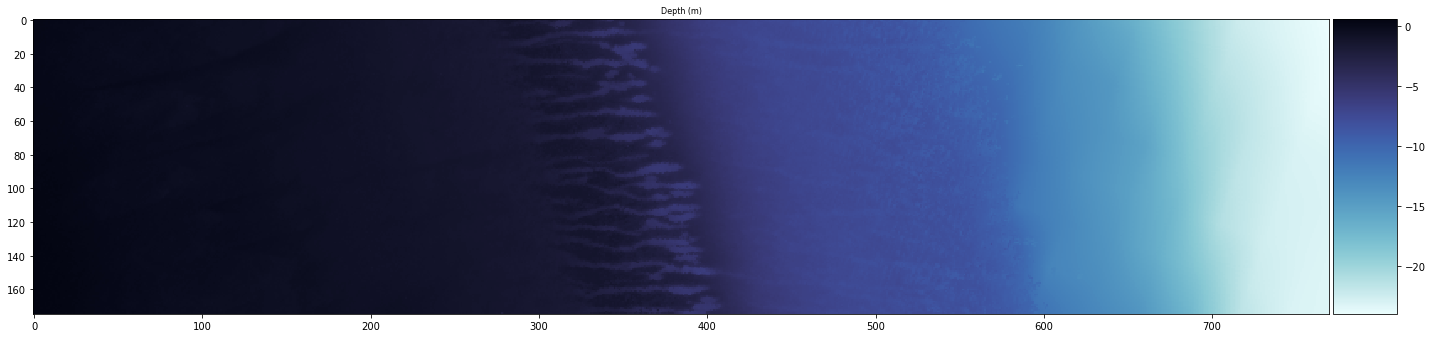

In [18]:
#plotData(np.fliplr(newZ2),None,fsize=(20,20))
plotData((newZ2),None,fsize=(20,20))

In [19]:
newZ2 = np.fliplr(newz.T)

In [20]:
newZ2.shape

(175, 770)

In [21]:
x = xi-llc1[0]
y = yi-llc1[1]
nx = len(x)
ny = len(y)
z = newz.flatten()
nz = len(z)

In [22]:
nx,ny

(175, 770)

Create x, y grids

In [23]:
def grd(x,nx,ny,y):
    
    syst='Coordinate System = Cartesian'
    nx_str=str(nx)
    ny_str=str(ny)
    nx_ny=nx_str+' '+ny_str
    list_header=[syst,nx_ny,'0 0 0','']
    header="\n".join(list_header)
    
    if (x[0]==x[1]):
        len_list=ny*2+(nx+1)*2*ny
        xy_list=['0']*len_list
        
        for l in range (0,2*ny):
            xy_list[l*(nx+2)]="ETA"
            xy_list[1+l*(nx+2)]=str(l%ny+1)
        
        y_start=2+(nx+2)*(ny)
        for i in range (0,ny):
            for j in range (0,nx):
                xy_list[2+(nx+2)*i+j]=str(x[i+j*ny])
                xy_list[y_start+(nx+2)*i+j]=str(y[i+j*ny])
                
        
    else:     
        len_list=ny*2+(nx+1)*2*ny
        xy_list=['0']*len_list
        
        for l in range (0,2*ny):
            xy_list[l*(nx+2)]="ETA"
            xy_list[1+l*(nx+2)]=str(l%ny+1)
        
        y_start=2+(nx+2)*(ny)
        for i in range (0,ny):
            for j in range (0,nx):
                xy_list[2+(nx+2)*i+j]=str(x[j+i*nx])
                xy_list[y_start+(nx+2)*i+j]=str(y[j+i*nx])
                
                
                
    xy=" ".join(xy_list)
    file_complete=header+xy
    newfile= open("xy.grd", "w")
    newfile.write(file_complete)
    newfile.close()
    
    dfile = file('xy.grd','r')
    efile = file('xy2.grd','w')
    efile.write(dfile.read().replace('ETA', '\nETA'))
    
    
    
    return
        

In [31]:
#dfile = file('untitled.txt','r')
#efile = file('untitled2.txt','w')
#efile.write(dfile.read().replace(' ', '\n '))

NameError: name 'file' is not defined

In [25]:
nx = len(xi)   #switch nx for ny to adjust rotation
ny = len(yi)
z = newZ2.flatten()
nz = len(z)
xx, yy = np.meshgrid(yi-llc1[1], xi-llc1[0])
xy = np.vstack((xx.flatten(),yy.flatten())).T
x = xy[:,0]
y = xy[:,1]
grd(x,nx,ny,y)

NameError: name 'file' is not defined

In [26]:
xx.shape,newZ2.shape

((175, 770), (175, 770))

In [27]:
grd(x,nx,ny,y)

NameError: name 'file' is not defined

In [28]:
ny

770

In [29]:
def bed(x,z,nz,nx,ny,rval=0,fval=0):
    bed_list=[]
    reef_list=[]
    fric_list=[]
    nx_value=''
    reef_nx_value=''
    fric_nx_value=''
    
    
    if (x[0]==x[1]):
        for i in range(0,ny):
            for j in range (0,nx):
                #nx_value=nx_value+str(-z[i+j*ny])+' '
                nx_value=str(-z[i+j*ny])+' '+nx_value
                reef_nx_value=reef_nx_value+str(rval)+' '
                fric_nx_value=fric_nx_value+str(fval)+' '
            bed_list=bed_list+[nx_value]
            reef_list=reef_list+[reef_nx_value]
            fric_list=reef_list+[fric_nx_value]
            nx_value=''
            reef_nx_value=''  
            fric_nx_value=''
        
        
        
    else:
        for j in range(0,ny):
            for i in range (0,nx):
                #nx_value=nx_value+str(-z[i+j*nx])+' '
                nx_value=str(-z[i+j*nx])+' '+nx_value
                reef_nx_value=reef_nx_value+str(rval)+' '
                fric_nx_value=fric_nx_value+str(fval)+' '
            bed_list=bed_list+[nx_value]
            reef_list=reef_list+[reef_nx_value]
            fric_list=reef_list+[fric_nx_value]
            nx_value=''
            reef_nx_value=''
            fric_nx_value=''
     
    bed="\n".join(bed_list)
    fric="\n".join(fric_list)
    reef="\n".join(reef_list)
    
    
    
    newfile= open("bed.dep", "w")
    newfile.write(bed)
    newfile.close()
    
    newfile= open("reef.dep", "w")
    newfile.write(reef)
    newfile.close()
    
    newfile= open("fric.dep", "w")
    newfile.write(fric)
    newfile.close()
    return

In [30]:
bed(x,z,nz,nx,ny,rval=0,fval=0)

# Create input waves for non-hydostatic mode

In [41]:
H=1.3 # amplitude of the sinusoidal u --> height of the wave
T=17 # period of the sinusoidal u --> The greater the period the larger the wave
T_wave=5 # period of the wave --> time between two waves
tstop=300
nonhyd=[]

#time = nc_data.variables['globaltime'][:]
time=np.arange(0,tstop,1)

u = H*np.sin(time*2*np.pi/T)+H
u_period=u[:T+1]

a = np.where(u_period==np.min(u_period))[0][0]

u_bis=u[a-1:a+T+1]
u_bis[0]=0.0

for j in range(0,tstop,size(u_bis)+T_wave):
    for i in range(0,size(u_bis)):
        if i+j < 300:
            value=str(time[i+j])+' '+str(u_bis[i])
            nonhyd=nonhyd+[value]
nhyd="\n".join(nonhyd)
newfile= open("Boun_U.bcf", "w")
newfile.write(nhyd)
newfile.close()

# this creates the numbers for the output, but you need to add this at the beginning of the file before giving it to XBeach.
#    scalar
#    2
#    t U

In [81]:
size(u_bis)+T_wave,size(u_bis)

(25, 19)

In [57]:
size(u_bis)+T_wave

24

In [44]:
u[:T+1]

array([ 1.3       ,  1.76961417,  2.17580434,  2.46371228,  2.59445443,
        2.55037334,  2.3374224 ,  1.98436181,  1.53887437,  1.06112563,
        0.61563819,  0.2625776 ,  0.        ,  0.00554557,  0.13628772,
        0.42419566,  0.83038583,  1.3       ])

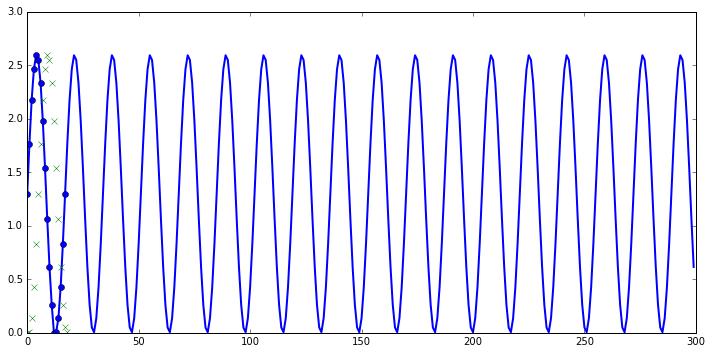

In [78]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(u, 'blue', linewidth=2)
ax1.plot(u_period, 'o')
ax1.plot(u_bis, 'x')
plt.tight_layout()
plt.show()
plt.close(fig)


In [65]:
u

array([ 1.3       ,  1.76961417,  2.17580434,  2.46371228,  2.59445443,
        2.55037334,  2.3374224 ,  1.98436181,  1.53887437,  1.06112563,
        0.61563819,  0.2625776 ,  0.        ,  0.00554557,  0.13628772,
        0.42419566,  0.83038583,  1.3       ,  1.76961417,  2.17580434,
        2.46371228,  2.59445443,  2.55037334,  2.3374224 ,  1.98436181,
        1.53887437,  1.06112563,  0.61563819,  0.2625776 ,  0.04962666,
        0.00554557,  0.13628772,  0.42419566,  0.83038583,  1.3       ,
        1.76961417,  2.17580434,  2.46371228,  2.59445443,  2.55037334,
        2.3374224 ,  1.98436181,  1.53887437,  1.06112563,  0.61563819,
        0.2625776 ,  0.04962666,  0.00554557,  0.13628772,  0.42419566,
        0.83038583,  1.3       ,  1.76961417,  2.17580434,  2.46371228,
        2.59445443,  2.55037334,  2.3374224 ,  1.98436181,  1.53887437,
        1.06112563,  0.61563819,  0.2625776 ,  0.04962666,  0.00554557,
        0.13628772,  0.42419566,  0.83038583,  1.3       ,  1.76

In [67]:
u[:T+1]

array([ 1.3       ,  1.76961417,  2.17580434,  2.46371228,  2.59445443,
        2.55037334,  2.3374224 ,  1.98436181,  1.53887437,  1.06112563,
        0.61563819,  0.2625776 ,  0.        ,  0.00554557,  0.13628772,
        0.42419566,  0.83038583,  1.3       ])